In [1]:
import torch
import discretize_distributions as dd
from discretize_distributions.utils import calculate_w2_disc_uni_stand_normal
from discretize_distributions.discretize import GRID_CONFIGS, OPTIMAL_1D_GRIDS, w2_multi_norm_dist_for_set_locations
from discretize_distributions.grid import Grid
from matplotlib import pyplot as plt, patches, cm
from scipy.spatial import Voronoi, voronoi_plot_2d
from discretize_distributions.distributions import DiscretizedMixtureMultivariateNormal, \
    DiscretizedMixtureMultivariateNormalQuantization, DiscretizedMixtureMultivariateNormalQuantizationShell
import GMMWas
import numpy as np

/Users/elizealwash/PycharmProjects/MSc_Thesis_code/.venv/lib/python3.9/site-packages/ot/lp/cvx.py:17: UserWarning: The module ot.lp.cvx is deprecated and will be removed in future versions.The function `barycenter` was moved to ot.lp._barycenter_solvers and canbe importer via ot.lp.
  warnings.warn(


Shelling on Gaussian

In [2]:
num_dims = 2
num_mix_elems0 = 1
batch_size = torch.Size()
torch.manual_seed(1)
locs = torch.randn(batch_size + (num_mix_elems0, num_dims,))
# only diagonal and pos def covariance matrices
covariance_diag = torch.exp(torch.randn(batch_size + (num_mix_elems0, num_dims,)))
covariance_matrix = torch.diag_embed(covariance_diag)

probs = torch.rand(batch_size + (num_mix_elems0,))
probs = probs / probs.sum(dim=-1, keepdim=True)

# creates gmm with only diagonal covariances
norm = dd.MultivariateNormal(
        loc=locs,
        covariance_matrix=covariance_matrix * (1 / (np.sqrt(num_dims)))  # scaling
    )

/Users/elizealwash/PycharmProjects/MSc_Thesis_code/.venv/lib/python3.9/site-packages/torch/distributions/distribution.py:56: UserWarning: <class 'discretize_distributions.distributions.multivariate_normal.MultivariateNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


W2-optimal signature for comparison of locations

In [3]:
disc_w2_optimal = dd.discretization_generator(norm, num_locs=100)  # w2 optimal grid
disc_locs = disc_w2_optimal.locs.squeeze(0)
disc_probs = disc_w2_optimal.probs.squeeze(0).detach().numpy()

Signature w2: 0.2150 / 1.4382 for grid of size: 99


Calculation of W2: 
$$
W_2^2(\mathbb{P},\Delta_{\mathcal{R,C}}\#\mathbb{P}) \leq \int_{\mathcal{R}_{1(k)}}\|x - c_k\|^2 \, d\mathbb{P}(x) \quad + \left( \int_{\mathbb{R}^n} \|x - z\|^2 \, d\mathbb{P}(x) 
- \int_{\mathcal{R}_{1}} \|x - z\|^2 \, d\mathbb{P}(x) \right)
$$


Part 1: Region inside R1

In [4]:
# shell around mean using standard deviation - but can be any region
mean = norm.mean.squeeze(0)
std = norm.stddev.squeeze(0)
shell_input = [(mean[0]-std[0], mean[0]+std[0]), (mean[1]-std[1], mean[1]+std[1])]
R1 = Grid.shell(shell_input, (10, 10))
disc_R1_locs, disc_R1_probs, w2_disc_R1 = dd.discretize_multi_norm_dist(norm, num_locs=None, grid=R1)
disc_R1_probs = disc_R1_probs.detach().numpy()  # mass in grid partitions

/Users/elizealwash/PycharmProjects/discretize_distributions/src/discretize_distributions/grid.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lower = torch.tensor(bound_lower, device=dim_locs.device, dtype=dim_locs.dtype)
/Users/elizealwash/PycharmProjects/discretize_distributions/src/discretize_distributions/grid.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upper = torch.tensor(bound_upper, device=dim_locs.device, dtype=dim_locs.dtype)


Plotting

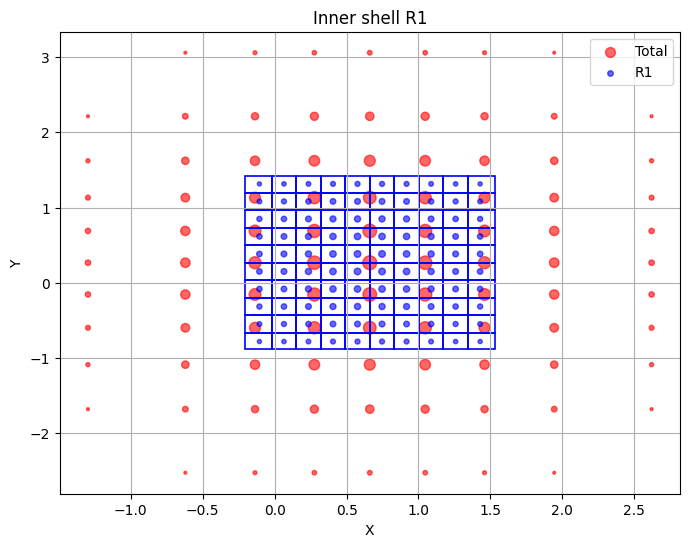

In [5]:
global_min = min(disc_R1_probs.min(), disc_probs.min())
global_max = max(disc_R1_probs.max(), disc_probs.max())
s1 = (disc_probs - global_min) / (global_max - global_min) * 100
s2 = (disc_R1_probs - global_min) / (global_max - global_min) * 100

core_lower_vertices_per_dim, core_upper_vertices_per_dim = R1.lower_vertices_per_dim, R1.upper_vertices_per_dim
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.scatter(disc_locs.detach().numpy()[:, 0], disc_locs.detach().numpy()[:, 1], s=s1, color='red', label='Total', alpha=0.6)
ax.scatter(disc_R1_locs.detach().numpy()[:, 0], disc_R1_locs.detach().numpy()[:, 1], s=s2, color='blue', label='R1', alpha=0.6)
for i in range(len(core_lower_vertices_per_dim[0])):
    for j in range(len(core_lower_vertices_per_dim[1])):
        x0 = core_lower_vertices_per_dim[0][i].item()
        x1 = core_upper_vertices_per_dim[0][i].item()
        y0 = core_lower_vertices_per_dim[1][j].item()
        y1 = core_upper_vertices_per_dim[1][j].item()
        rect = patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            edgecolor='blue',
            facecolor='none',
            linewidth=1.2,
            linestyle='-'
        )
        ax.add_patch(rect)

ax.set_title('Inner shell R1')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid(True)
plt.show()

Part 2: Calculation of whole space $\mathbb{R}^n$ for location z

In [6]:
z = mean  # cn be arbitrary z location, choose mean as most optimal
R1_inner = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)])
disc_R1_inner_locs, disc_R1_inner_probs, w2_disc_R1_inner = dd.discretize_multi_norm_dist(norm, num_locs=None,
                                                                                              grid=R1_inner)
disc_R1_inner_probs = disc_R1_inner_probs.detach().numpy()  # mass in grid partitions

Part 3: Calculation of space inside boundary R1 for location z

In [7]:
R1_outer = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)], bounds=shell_input)

R1_lower_vertices_per_dim, R1_upper_vertices_per_dim = (R1_outer.lower_vertices_per_dim,
                                                        R1_outer.upper_vertices_per_dim)
disc_R1_outer_locs, disc_R1_outer_probs, w2_disc_R1_outer = dd.discretize_multi_norm_dist(norm, num_locs=None,
                                                                                              grid=R1_outer)
disc_R1_outer_probs = disc_R1_outer_probs.detach().numpy()  # mass in grid partitions

W2 Calculations

In [8]:
# W2 calc
print(f'W2 error R1(k): {w2_disc_R1.item()}')
print(f'W2 error outer region R^n with z: {w2_disc_R1_inner}')
print(f'W2 error inner R1 with z: {w2_disc_R1_outer.item()}')
print(f"Total W2: R1(k) + (R^n with z - R1 with z) = {w2_disc_R1.item() + (w2_disc_R1_inner-w2_disc_R1_outer.item())}")
print(f'Prob mass inside R1: {disc_R1_probs.sum()}')  
print(f'Prob mass outside R1, mass of z: 1-R1 = {1-disc_R1_probs.sum()}')

W2 error R1(k): 0.06757190823554993
W2 error outer region R^n with z: 1.4142135381698608
W2 error inner R1 with z: 0.6304727792739868
Total W2: R1(k) + (R^n with z - R1 with z) = 0.8513126373291016
Prob mass inside R1: 0.46606484055519104
Prob mass outside R1, mass of z: 1-R1 = 0.5339351892471313


Plotting

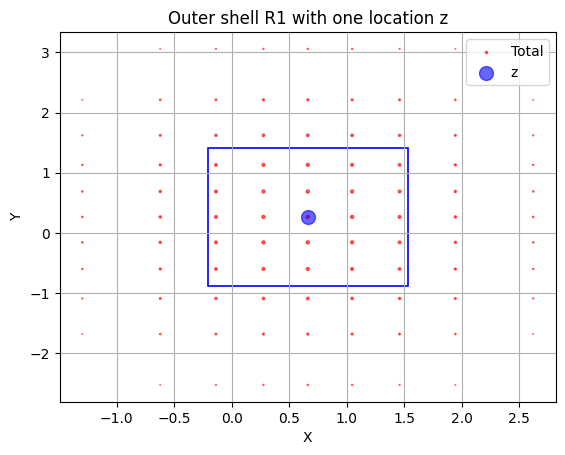

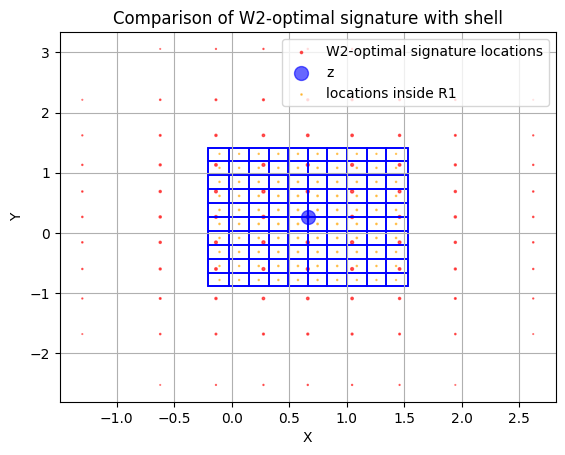

In [9]:
global_min = min(disc_R1_outer_probs.min(), disc_probs.min())
global_max = max(disc_R1_outer_probs.max(), disc_probs.max())
s1 = (disc_probs - global_min) / (global_max - global_min) * 100
s3 = (disc_R1_outer_probs - global_min) / (global_max - global_min) * 100

plt.figure()
ax = plt.gca()
ax.scatter(disc_locs.detach().numpy()[:, 0], disc_locs.detach().numpy()[:, 1], s=s1, color='red', label='Total',
           alpha=0.6)
ax.scatter(disc_R1_outer_locs.detach().numpy()[:, 0], disc_R1_outer_locs.detach().numpy()[:, 1],
           s=s3, color='blue', label='z',
           alpha=0.6)
x0 = R1_lower_vertices_per_dim[0].item()
x1 = R1_upper_vertices_per_dim[0].item()
y0 = R1_lower_vertices_per_dim[1].item()
y1 = R1_upper_vertices_per_dim[1].item()
rect = patches.Rectangle(
    (x0, y0),
    x1 - x0,
    y1 - y0,
    edgecolor='blue',
    facecolor='none',
    linewidth=1.2,
    linestyle='-'
)
ax.add_patch(rect)
ax.set_title('Outer shell R1 with one location z')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid(True)
plt.show()

# redefine prob mass relative to all grids
global_min = min(disc_R1_probs.min(), disc_probs.min(), disc_R1_outer_probs.min())
global_max = max(disc_R1_probs.max(), disc_probs.max(), disc_R1_outer_probs.max())
s1 = (disc_probs - global_min) / (global_max - global_min) * 100
s2 = (disc_R1_probs - global_min) / (global_max - global_min) * 100
s3 = (disc_R1_outer_probs - global_min) / (global_max - global_min) * 100

plt.figure()
ax = plt.gca()
ax.scatter(disc_locs.detach().numpy()[:, 0], disc_locs.detach().numpy()[:, 1], s=s1, color='red', label='W2-optimal signature locations',
           alpha=0.6)
ax.scatter(disc_R1_outer_locs.detach().numpy()[:, 0], disc_R1_outer_locs.detach().numpy()[:, 1],
           s=s3, color='blue', label='z',
           alpha=0.6)
ax.scatter(disc_R1_locs.detach().numpy()[:, 0], disc_R1_locs.detach().numpy()[:, 1], s=s2, color='orange', label='locations inside R1', alpha=0.6)
for i in range(len(core_lower_vertices_per_dim[0])):
    for j in range(len(core_lower_vertices_per_dim[1])):
        x0 = core_lower_vertices_per_dim[0][i].item()
        x1 = core_upper_vertices_per_dim[0][i].item()
        y0 = core_lower_vertices_per_dim[1][j].item()
        y1 = core_upper_vertices_per_dim[1][j].item()
        rect = patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            edgecolor='blue',
            facecolor='none',
            linewidth=1.2,
            linestyle='-'
        )
        ax.add_patch(rect)

x0 = R1_lower_vertices_per_dim[0].item()
x1 = R1_upper_vertices_per_dim[0].item()
y0 = R1_lower_vertices_per_dim[1].item()
y1 = R1_upper_vertices_per_dim[1].item()
rect = patches.Rectangle(
    (x0, y0),
    x1 - x0,
    y1 - y0,
    edgecolor='blue',
    facecolor='none',
    linewidth=1.2,
    linestyle='-'
)
ax.add_patch(rect)
ax.set_title('Comparison of W2-optimal signature with shell')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid(True)
plt.show()

Shelling on GMMs!

Setup:

In [10]:
num_mix_elems0 = 3
locs = torch.randn(batch_size + (num_mix_elems0, num_dims,))
# only diagonal and pos def covariance matrices
covariance_diag = torch.exp(torch.randn(batch_size + (num_mix_elems0, num_dims,)))
covariance_matrix = torch.diag_embed(covariance_diag)

probs = torch.rand(batch_size + (num_mix_elems0,))
probs = probs / probs.sum(dim=-1, keepdim=True)

gmm = dd.MixtureMultivariateNormal(
    mixture_distribution=torch.distributions.Categorical(probs=probs),
    component_distribution=dd.MultivariateNormal(
        loc=locs,
        covariance_matrix=covariance_matrix * (1 / (np.sqrt(num_dims)))  # scaling
    )
)

Each a seperate grid based on mean and std of each Gaussian component. So W2 calculation is done per component, where R1 is also defined per component:
$$
W_2^2(\mathbb{P},\Delta_{\mathcal{R,C}}\#\mathbb{P}) \leq \int_{\mathcal{R}_{1(k)}}\|x - c_k\|^2 \, d\mathbb{P}(x) \quad + \left( \int_{\mathbb{R}^n} \|x - z\|^2 \, d\mathbb{P}(x) 
- \int_{\mathcal{R}_{1}} \|x - z\|^2 \, d\mathbb{P}(x) \right)
$$
Then the W2's per component are weighted for the whole GMM, where R and C are the union of R1's and C's per component (which does not work when component's grids' overlap!):
$$
W_2^2(\Delta_{\mathcal{C,R}}\#\mathbb{P},\mathbb{P}) \leq \sum^M_{i=1} \bar{\pi}_i W_2^2(\Delta_{\mathcal{C,R}}\#\mathbb{P}_i, \mathbb{P}_i)
$$



In [11]:
# each separate grids
disc_gmm = DiscretizedMixtureMultivariateNormalQuantizationShell(gmm)

# stats
locs = disc_gmm.locs.detach().numpy()
probs = disc_gmm.probs.detach().numpy()
s = (probs - probs.min()) / (probs.max() - probs.min()) * 100
print(f"Total W2 error: {disc_gmm.w2.item()}")

Using separate shell logic
prob R1 sum: 0.9110701084136963
prob R1-1: 0.08892989158630371, at location: tensor([-0.6617, -0.0426])
w2 error for component 0: 0.16272354125976562
prob R1 sum: 0.9110701084136963
prob R1-1: 0.08892989158630371, at location: tensor([-1.3328,  0.5161])
w2 error for component 1: 0.16790425777435303
prob R1 sum: 0.9110701084136963
prob R1-1: 0.08892989158630371, at location: tensor([ 0.7455, -0.0751])
w2 error for component 2: 0.1612185686826706
Total W2 error: 0.16193383932113647


Plotting

/var/folders/sd/n2j1hc_53yz7836gsynvkwpc0000gn/T/ipykernel_29875/262937253.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


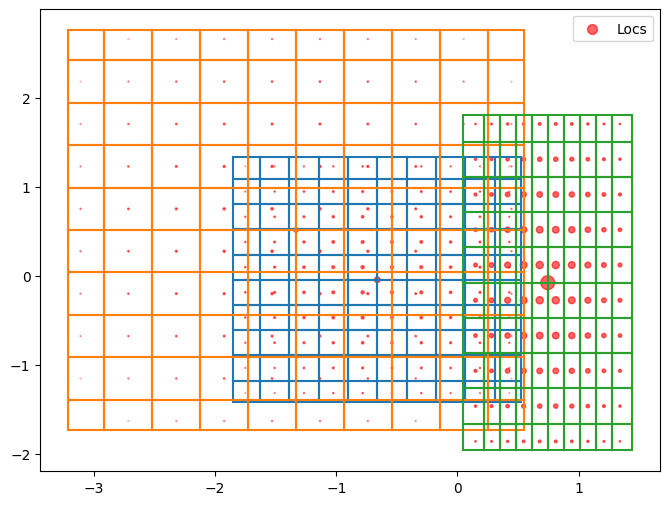

In [12]:

cmap = plt.cm.get_cmap('tab10')
# multiple shells
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.scatter(locs[:, 0], locs[:, 1], label='Locs', s=s, color='red', alpha=0.6)
for idx, R1 in enumerate(disc_gmm.R1_grids):
    core_lower_vertices_per_dim = R1.lower_vertices_per_dim
    core_upper_vertices_per_dim = R1.upper_vertices_per_dim
    color = cmap(idx % 10)
    for i in range(len(core_lower_vertices_per_dim[0])):
        for j in range(len(core_lower_vertices_per_dim[1])):
            x0 = core_lower_vertices_per_dim[0][i].item()
            x1 = core_upper_vertices_per_dim[0][i].item()
            y0 = core_lower_vertices_per_dim[1][j].item()
            y1 = core_upper_vertices_per_dim[1][j].item()

            rect = patches.Rectangle(
                (x0, y0),
                x1 - x0,
                y1 - y0,
                edgecolor=color,
                facecolor='none',
                linewidth=1.5,
                linestyle='-'
            )
            ax.add_patch(rect)
plt.legend()
plt.show()

Same grid for whole GMM. W2 calculation stays the same as before, but now it's not component wise, it's for the WHOLE distribution. So each part of the equation is found for the whole GMM using:
$$
W_2^2(\Delta_{\mathcal{C,R}}\#\mathbb{P},\mathbb{P}) \leq \sum^M_{i=1} \bar{\pi}_i W_2^2(\Delta_{\mathcal{C,R}}\#\mathbb{P}_i, \mathbb{P}_i)
$$
The R and C are defined by:

$$
\{\mathcal{C,R}\} := \{\{\mathcal{R}_1,\mathcal{R}_2\},\{\mathcal{C}_1,\mathcal{C}_2\}\}
$$

- The shell region $\mathcal{R}_1$ and corresponding locations inside shell $\mathcal{C}_1$
- Outer region $\mathcal{R}_2 = \mathbb{R}^n \setminus \mathcal{R}_1$ with location $\mathcal{C}_2 = z$

Then they are added/subtracted back together according to:
$$
W_2^2(\mathbb{P},\Delta_{\mathcal{R,C}}\#\mathbb{P}) \leq \int_{\mathcal{R}_{1(k)}}\|x - c_k\|^2 \, d\mathbb{P}(x) \quad + \left( \int_{\mathbb{R}^n} \|x - z\|^2 \, d\mathbb{P}(x) 
- \int_{\mathcal{R}_{1}} \|x - z\|^2 \, d\mathbb{P}(x) \right)
$$

Grid R1 setup

In [26]:
shell_input = [(torch.tensor(-1.0), torch.tensor(1.0)), (torch.tensor(-1.0), torch.tensor(1.0))]
R1_grid = Grid.shell(shell_input, (10, 10))
locs_R1 = R1_grid.get_locs()

Choose z location for whole GMM

In [27]:
locs_p = gmm.component_distribution.loc  # [num_components, dim]
z = locs_p[2, :]  # can be any arbitrary location
# z = torch.tensor([2.0, 2.0])  

Calculation of W2 inside R1 region 

In [28]:
# calc w2 for R1(k)
disc_R1 = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_grid)
probs_R1, w2_R1, z_probs_R1 = disc_R1.probs, disc_R1.w2.item(), disc_R1.z_probs   # probs already weighted by components to add to 1 ...
print(f"W2 inside R1 grid: {w2_R1}")

W2 inside R1 grid: 0.14372357726097107


Calc of W2 for outer region for location z

In [29]:
# calc w2 for R^n with z - should just be same as R1_inner with unbounded region
# w2_Rn = w2_multi_norm_dist_for_set_locations(norm=component_p, signature_locs=z)
R1_outer = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)])
disc_R1_outer = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_outer)
w2_R1_outer = disc_R1_outer.w2.item()
print(f'W2 R1 outer: {w2_R1_outer}')

W2 R1 outer: 1.773738145828247


Calc of W2 for inner region for location z

In [30]:
# calc w2 for R1 with z
R1_inner = Grid(locs_per_dim=[z[0].unsqueeze(0), z[1].unsqueeze(0)], bounds=shell_input)
disc_R1_inner = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=R1_inner)
w2_R1_inner = disc_R1_inner.w2.item()
print(f'W2 R1 inner: {w2_R1_inner}')

W2 R1 inner: 1.0609626770019531


Total W2

In [31]:
# total w2 per component
w2_p = w2_R1 + (w2_R1_outer - w2_R1_inner)
print(f'W2 error for whole GMM: {w2_p}')

# z location and mass
print(f'Prob R1 sum: {probs_R1.sum()}')
print(f'Prob mass of z: R1-1 = {z_probs_R1.item()}, at location: {z}')

locs_ = torch.cat([locs_R1, z.unsqueeze(0)], dim=0)
probs_ = torch.cat([probs_R1, z_probs_R1], dim=0)  # need to normalize ?
print(f'Total probs: {probs_.sum()}')
print(f'Prob R1 sum normalized: {(probs_R1.sum() / probs_.sum(dim=-1, keepdim=True)).item()}')
print(f'Prob mass of z normalized: R1-1 = {(z_probs_R1.sum() / probs_.sum(dim=-1, keepdim=True)).item()}')
probs_ = probs_ / probs_.sum(dim=-1, keepdim=True)
print(f'Total probs normalized: {probs_.sum()}')

W2 error for whole GMM: 0.856499046087265
Prob R1 sum: 1.0
Prob mass of z: R1-1 = 0.4717707633972168, at location: tensor([ 0.7455, -0.0751])
Total probs: 1.4717707633972168
Prob R1 sum normalized: 0.6794536113739014
Prob mass of z normalized: R1-1 = 0.32054635882377625
Total probs normalized: 1.0


Plotting

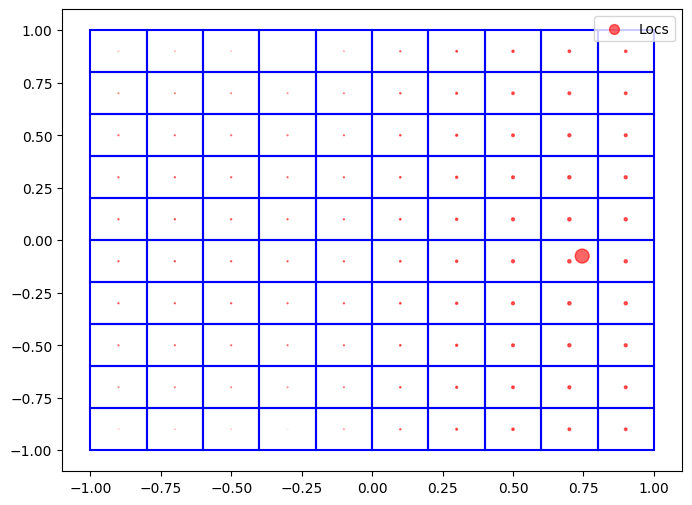

In [32]:
s = (probs_ - probs_.min()) / (probs_.max() - probs_.min()) * 100
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.scatter(locs_[:, 0], locs_[:, 1], label='Locs', s=s, color='red', alpha=0.6)
core_lower_vertices_per_dim = R1_grid.lower_vertices_per_dim
core_upper_vertices_per_dim = R1_grid.upper_vertices_per_dim
for i in range(len(core_lower_vertices_per_dim[0])):
    for j in range(len(core_lower_vertices_per_dim[1])):
        x0 = core_lower_vertices_per_dim[0][i].item()
        x1 = core_upper_vertices_per_dim[0][i].item()
        y0 = core_lower_vertices_per_dim[1][j].item()
        y1 = core_upper_vertices_per_dim[1][j].item()
        rect = patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            edgecolor='blue',
            facecolor='none',
            linewidth=1.5,
            linestyle='-'
        )
        ax.add_patch(rect)
plt.legend()
plt.show()

Now using multiple shells on the whole GMM1